In [75]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib import rcParams
import matplotlib.ticker as ticker
import numpy as np
import datetime

import os
path = os.getcwd()

In [76]:
# imports
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import RobustScaler
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import FunctionTransformer
from sklearn.compose import make_column_selector
from sklearn.model_selection import train_test_split
from sklearn.pipeline import make_pipeline
from sklearn.pipeline import make_union
from sklearn.compose import make_column_transformer
from sklearn import set_config
from sklearn.linear_model import Ridge
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Lasso
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score

In [77]:
df= pd.read_csv('UPDATE_full_data_clean_inclCluster.csv')
df.head()

,Unnamed: 0,Unnamed: 0.1,Store ID,Item ID,Store Category,Store Segment,Store Region,City,Store Address,Item First Supplying Date,...,Count Ratings,Declared Supply,Meals Saved,Total Supply,Avg Rating Overall,Pickup Length,Supply Length,Region Language,Region Type,Cluster
0,0,0,11344,11438,Key Account,Bakery,Genève,GenÃ¨ve,Place de Cornavin 7,2017-12-07 00:00:00,...,0,20,2,20,0.00,0 days 00:50:00,1545,french,urban,0
1,1,1,11729,11822,Indie - Outbound,Buffet,Bern,Bern,LÃ¤nggassstrasse 53,2018-11-02 00:00:00,...,1,0,9,16,4.00,0 days 04:00:00,237,german,urban,0
2,2,2,11729,11822,Indie - Outbound,Buffet,Bern,Bern,LÃ¤nggassstrasse 53,2018-11-02 00:00:00,...,8,0,28,33,4.25,0 days 04:00:00,237,german,urban,0
3,3,3,11729,11822,Indie - Outbound,Buffet,Bern,Bern,LÃ¤nggassstrasse 53,2018-11-02 00:00:00,...,0,10,11,17,0.00,0 days 04:00:00,237,german,urban,0
4,4,4,11729,11822,Indie - Outbound,Buffet,Bern,Bern,LÃ¤nggassstrasse 53,2018-11-02 00:00:00,...,1,10,13,17,5.00,0 days 04:00:00,237,german,urban,0


In [78]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2616743 entries, 0 to 2616742
Data columns (total 25 columns):
 #   Column                         Dtype  
---  ------                         -----  
 0   Unnamed: 0                     int64  
 1   Unnamed: 0.1                   int64  
 2   Store ID                       int64  
 3   Item ID                        int64  
 4   Store Category                 object 
 5   Store Segment                  object 
 6   Store Region                   object 
 7   City                           object 
 8   Store Address                  object 
 9   Item First Supplying Date      object 
 10  Item Last Supplying Date       object 
 11  Item Price                     float64
 12  Pickup Time Start Time of Day  object 
 13  Pickup Time End Time of Day    object 
 14  Date                           object 
 15  Count Ratings                  int64  
 16  Declared Supply                int64  
 17  Meals Saved                    int64  
 18  To

## Data Preprocessing

In [79]:
# Check for duplicates
df.duplicated().sum()

0

In [80]:
# Check for nan:
df.isnull().sum().sort_values(ascending=False)

Unnamed: 0                       0
Pickup Time End Time of Day      0
Region Type                      0
Region Language                  0
Supply Length                    0
Pickup Length                    0
Avg Rating Overall               0
Total Supply                     0
Meals Saved                      0
Declared Supply                  0
Count Ratings                    0
Date                             0
Pickup Time Start Time of Day    0
Unnamed: 0.1                     0
Item Price                       0
Item Last Supplying Date         0
Item First Supplying Date        0
Store Address                    0
City                             0
Store Region                     0
Store Segment                    0
Store Category                   0
Item ID                          0
Store ID                         0
Cluster                          0
dtype: int64

In [81]:
# Check for date columns to remove:
df[['Date','Item First Supplying Date','Item Last Supplying Date','Pickup Time Start Time of Day','Pickup Time End Time of Day']].head()

,Date,Item First Supplying Date,Item Last Supplying Date,Pickup Time Start Time of Day,Pickup Time End Time of Day
0,2019-01-01 00:00:00,2017-12-07 00:00:00,2022-03-01 00:00:00,1900-01-01 20:00:00,1900-01-01 20:50:00
1,2019-01-01 00:00:00,2018-11-02 00:00:00,2019-06-27 00:00:00,1900-01-01 18:30:00,1900-01-01 22:30:00
2,2019-01-02 00:00:00,2018-11-02 00:00:00,2019-06-27 00:00:00,1900-01-01 18:30:00,1900-01-01 22:30:00
3,2019-01-27 00:00:00,2018-11-02 00:00:00,2019-06-27 00:00:00,1900-01-01 18:30:00,1900-01-01 22:30:00
4,2019-01-31 00:00:00,2018-11-02 00:00:00,2019-06-27 00:00:00,1900-01-01 18:30:00,1900-01-01 22:30:00


### Add column to cluster Pickup start time

In [82]:
# Add column to cluster Pickup start time:
conditions = [
    (df['Pickup Time Start Time of Day'] <= "1900-01-01 11:59:00"),
    (df['Pickup Time Start Time of Day'] >= "1900-01-01 12:00:00") & (df['Pickup Time Start Time of Day'] < "1900-01-01 17:00:00"),
    (df['Pickup Time Start Time of Day'] >= "1900-01-01 17:00:00") & (df['Pickup Time Start Time of Day'] < "1900-01-01 21:00:00"),
    (df['Pickup Time Start Time of Day'] >= "1900-01-01 21:00:00")
    ]

values = ['morning', 'afternoon', 'early evening', 'late evening']

df['Pickp_time_of_day'] = np.select(conditions, values)

###  Convert Pickup Length

In [83]:
# Fuction to convert:
def pickup_conv(x):
    x=str(x)
    x=x[len(x)-8:len(x)]
    h,m,s = x.split(':')
    x=int((datetime.timedelta(hours=int(h),minutes=int(m),seconds=int(s)).total_seconds())/60)
    return x

In [84]:
#Converting the whole column
df['Pickup Length']=df['Pickup Length'].map(pickup_conv)

In [85]:
df.head(3)

,Unnamed: 0,Unnamed: 0.1,Store ID,Item ID,Store Category,Store Segment,Store Region,City,Store Address,Item First Supplying Date,...,Declared Supply,Meals Saved,Total Supply,Avg Rating Overall,Pickup Length,Supply Length,Region Language,Region Type,Cluster,Pickp_time_of_day
0,0,0,11344,11438,Key Account,Bakery,Genève,GenÃ¨ve,Place de Cornavin 7,2017-12-07 00:00:00,...,20,2,20,0.00,50,1545,french,urban,0,early evening
1,1,1,11729,11822,Indie - Outbound,Buffet,Bern,Bern,LÃ¤nggassstrasse 53,2018-11-02 00:00:00,...,0,9,16,4.00,240,237,german,urban,0,early evening
2,2,2,11729,11822,Indie - Outbound,Buffet,Bern,Bern,LÃ¤nggassstrasse 53,2018-11-02 00:00:00,...,0,28,33,4.25,240,237,german,urban,0,early evening


### Define Features

In [103]:
from sklearn.inspection import permutation_importance

lin_model = LinearRegression().fit(X_train, y_train) # Fit model

permutation_score = permutation_importance(lin_model, X_train, y_train, n_repeats=10) # Perform Permutation

importance_df = pd.DataFrame(np.vstack((X_train.columns,
                                        permutation_score.importances_mean)).T) # Unstack results
importance_df.columns=['feature','score decrease']

importance_df.sort_values(by="score decrease", ascending = False) # Order by importance

ValueError: could not convert string to float: 'Key Account'

### Define X and y

In [86]:
# Remove columns: define X and y
X = df.drop(columns=['Item Price','Unnamed: 0','Unnamed: 0.1','Store ID','Item ID','Date','Item First Supplying Date','Item Last Supplying Date','Pickup Time Start Time of Day','Pickup Time End Time of Day','City','Store Address', "Total Supply"])
y = df['Item Price']

In [87]:
X.head()

,Store Category,Store Segment,Store Region,Count Ratings,Declared Supply,Meals Saved,Avg Rating Overall,Pickup Length,Supply Length,Region Language,Region Type,Cluster,Pickp_time_of_day
0,Key Account,Bakery,Genève,0,20,2,0.00,50,1545,french,urban,0,early evening
1,Indie - Outbound,Buffet,Bern,1,0,9,4.00,240,237,german,urban,0,early evening
2,Indie - Outbound,Buffet,Bern,8,0,28,4.25,240,237,german,urban,0,early evening
3,Indie - Outbound,Buffet,Bern,0,10,11,0.00,240,237,german,urban,0,early evening
4,Indie - Outbound,Buffet,Bern,1,10,13,5.00,240,237,german,urban,0,early evening


In [88]:
X.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2616743 entries, 0 to 2616742
Data columns (total 13 columns):
 #   Column              Dtype  
---  ------              -----  
 0   Store Category      object 
 1   Store Segment       object 
 2   Store Region        object 
 3   Count Ratings       int64  
 4   Declared Supply     int64  
 5   Meals Saved         int64  
 6   Avg Rating Overall  float64
 7   Pickup Length       int64  
 8   Supply Length       int64  
 9   Region Language     object 
 10  Region Type         object 
 11  Cluster             int64  
 12  Pickp_time_of_day   object 
dtypes: float64(1), int64(6), object(6)
memory usage: 259.5+ MB


In [89]:
X.describe()

,Count Ratings,Declared Supply,Meals Saved,Avg Rating Overall,Pickup Length,Supply Length,Cluster
count,2.616743e+06,2.616743e+06,2.616743e+06,2.616743e+06,2.616743e+06,2.616743e+06,2.616743e+06
mean,6.495097e-01,2.236136e+00,1.752282e+00,2.003468e+00,4.856899e+01,7.092476e+02,1.599506e+00
std,9.427872e-01,2.092234e+00,2.099286e+00,2.300168e+00,7.977479e+01,3.384196e+02,1.155228e+00
min,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
25%,0.000000e+00,1.000000e+00,0.000000e+00,0.000000e+00,3.000000e+01,4.700000e+02,1.000000e+00
50%,0.000000e+00,2.000000e+00,1.000000e+00,0.000000e+00,3.000000e+01,7.180000e+02,2.000000e+00
75%,1.000000e+00,3.000000e+00,2.000000e+00,5.000000e+00,3.000000e+01,9.850000e+02,3.000000e+00
max,9.400000e+01,9.990000e+02,8.000000e+02,5.000000e+00,1.410000e+03,1.550000e+03,3.000000e+00


# Model 1: y=Price

In [90]:
# Split into Train/Test -> to do on all dataset
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state =42)

In [95]:
num_transformer = make_pipeline(RobustScaler())    #### Removed Simple Imputer
cat_transformer = make_pipeline(OneHotEncoder(handle_unknown='ignore'))
preprocess = make_column_transformer((num_transformer, ['Count Ratings', 'Declared Supply', 'Meals Saved', 'Avg Rating Overall','Pickup Length','Supply Length']),
                                     (cat_transformer,['Store Category', 'Store Segment', 'Store Region', 'Region Language', 'Region Type','Pickp_time_of_day','Cluster']))

In [96]:
# visualizing pipelines in HTML
#set_config(display='diagram')
#preprocess

In [97]:
#preprocess.fit(X_train)
X_train_transformed = preprocess.fit_transform(X_train)

In [98]:
display(pd.DataFrame(X_train_transformed.todense()).head(3))

,0,1,2,3,4,5,6,7,8,9,...,62,63,64,65,66,67,68,69,70,71
0,0.0,-0.5,0.0,0.0,0.0,-0.213592,0.0,0.0,1.0,0.0,...,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0
1,0.0,0.5,0.0,0.0,0.0,-0.508738,0.0,0.0,1.0,0.0,...,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0
2,0.0,0.0,0.0,0.0,0.0,0.056311,0.0,1.0,0.0,0.0,...,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0


In [99]:
# Add Estimator
#pipe = make_pipeline(preprocess, Ridge())
pipe = make_pipeline(preprocess, LinearRegression())
pipe

Pipeline(memory=None,
         steps=[('columntransformer',
                 ColumnTransformer(n_jobs=None, remainder='drop',
                                   sparse_threshold=0.3,
                                   transformer_weights=None,
                                   transformers=[('pipeline-1',
                                                  Pipeline(memory=None,
                                                           steps=[('robustscaler',
                                                                   RobustScaler(copy=True,
                                                                                quantile_range=(25.0,
                                                                                                75.0),
                                                                                with_centering=True,
                                                                                with_scaling=True))],
                                      

In [100]:
# Train pipeline
pipe.fit(X_train,y_train)

# Make predictions
pipe.predict(X_test)

# Score model
pipe.score(X_test,y_test)

0.3360198511430318

In [101]:
# Cross validate pipeline
cross_val_score(pipe, X_train, y_train, cv=5, scoring='r2').mean()

0.3363096461662412

<AxesSubplot:>

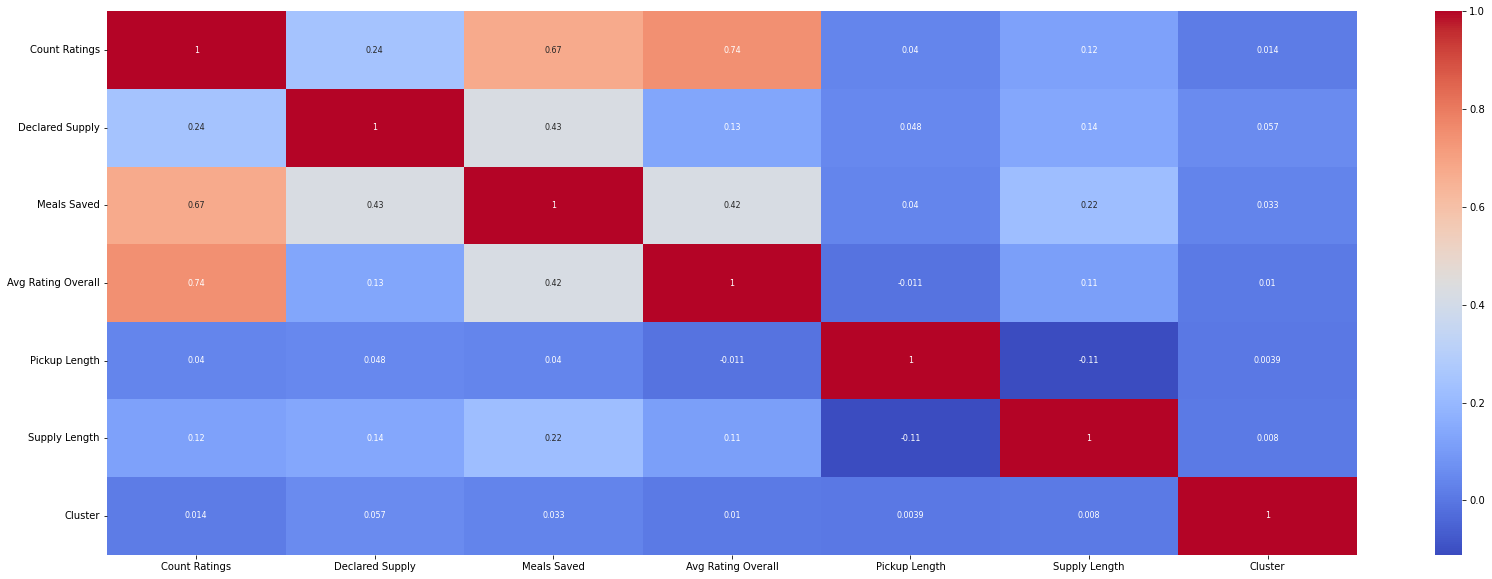

In [106]:
# Checking correlation between independent variables (features):
# Need to encode categorical variables
plt.figure(figsize=(28,10))
sns.heatmap(X_train.corr(), cmap='coolwarm', annot = True, annot_kws={"size": 8})

<AxesSubplot:>

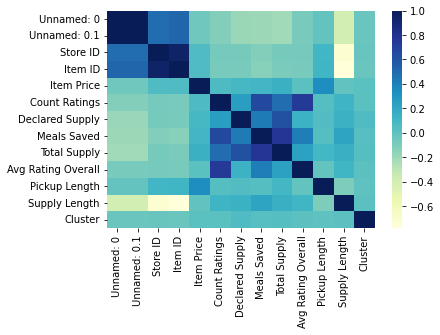

In [107]:
import seaborn as sns

# Heatmap
corr = df.corr()
sns.heatmap(corr, 
        xticklabels=corr.columns,
        yticklabels=corr.columns,
        cmap= "YlGnBu")

In [111]:
corr_df = corr.unstack().reset_index() # Unstack correlation matrix 
corr_df.columns = ['feature_1','feature_2', 'correlation'] # rename columns
corr_df.sort_values(by="correlation",ascending=False, inplace=True) # sort by correlation
corr_df = corr_df[corr_df['feature_1'] != corr_df['feature_2']] # Remove self correlation
corr_df.head()

,feature_1,feature_2,correlation
1,Unnamed: 0,Unnamed: 0.1,0.999999
13,Unnamed: 0.1,Unnamed: 0,0.999999
29,Store ID,Item ID,0.942659
41,Item ID,Store ID,0.942659
99,Meals Saved,Total Supply,0.767613
